# Mixtec Gender Classification

### Imports

In [1]:
%matplotlib inline
# %pip install pandas numpy torcheval torch matplotlib
import os

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torchvision import datasets, transforms

from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

from torch.utils.data.sampler import WeightedRandomSampler

torch.manual_seed(42)

### Define hardware

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda


NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Define path to images

In [3]:
basepath = Path(f'/home/{os.environ["USER"]}/toorange/alexwebber/mixteclabeling') # Base data directory
path = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'

### Load figures into dataset

In [4]:
## Load CSV
mixtec_figures = pd.read_csv(basepath / "data/mixtec_figures.csv")

print(mixtec_figures['gender'].value_counts())

## Define image transforms
## List of transforms https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((227, 227), antialias=True),
     # transforms.Grayscale(),
     transforms.ColorJitter(contrast=0.5),
     transforms.RandomRotation(360),     # Maybe useful for standng and sitting
     transforms.RandomHorizontalFlip(50),
     transforms.RandomVerticalFlip(50)
])

## Load images into PyTorch dataset
figures_dataset = datasets.ImageFolder(path, transform=transform)

print(figures_dataset)

gender
male      429
female     45
Name: count, dtype: int64
Dataset ImageFolder
    Number of datapoints: 210
    Root location: /home/christan/toorange/alexwebber/mixteclabeling/data/labeled_figures/codex_vindobonensis/gender
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
               ColorJitter(brightness=None, contrast=(0.5, 1.5), saturation=None, hue=None)
               RandomRotation(degrees=[-360.0, 360.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=50)
               RandomVerticalFlip(p=50)
           )


### Assign classes to map

In [5]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

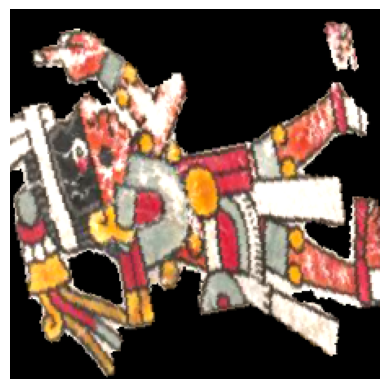

In [6]:
# Access a random image from the dataset
random_index = np.random.randint(len(figures_dataset))
image, label = figures_dataset[random_index]

# Convert the image tensor to a NumPy array and transpose it
image = image.permute(1, 2, 0)
image = image.numpy()

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

## Split datasets into training and testing sets

In [7]:
def count_classes(dataset, n_classes=2):
    image_count = [0]*(n_classes)
    for img in dataset:
        image_count[img[1]] += 1
    return image_count

def sampler_(dataset, n_classes=2):
    dataset_counts = count_classes(dataset)
    num_samples = len(dataset_counts)
    labels = [tag for _,tag in dataset]

    class_weights = [num_samples/dataset_counts[i] for i in range(n_classes)]
    weights = [class_weights[labels[i]] for i in range(num_samples)]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)
    return sampler

In [8]:
batch_size = 50

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

sampler = sampler_(train_set.dataset)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler=sampler)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

# Training

### Define CNN

In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x


# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Define hyperparameters

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [11]:
# data = train_loader

### Train model

In [12]:
cnn.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        outputs = cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
        
            running_loss = 0.0

print('Finished Training')


Epoch: 1 | Loss: 8.03228759765625
Epoch: 2 | Loss: 7.821743011474609
Epoch: 3 | Loss: 7.407812595367432
Epoch: 4 | Loss: 6.941779136657715
Epoch: 5 | Loss: 5.851655006408691
Epoch: 6 | Loss: 4.1067328453063965
Epoch: 7 | Loss: 1.897808313369751
Epoch: 8 | Loss: 0.020931124687194824
Epoch: 9 | Loss: 0.0003348424506839365
Epoch: 10 | Loss: 9.536734069115482e-07
Finished Training


### View incorrectly labeled samples

In [13]:
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

In [14]:
for i, data in enumerate(train_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.cpu().numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [15]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), savepath)

### Visualize learning

In [16]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mixtec_experiment_gender')

### Define tensorboard output function

In [17]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

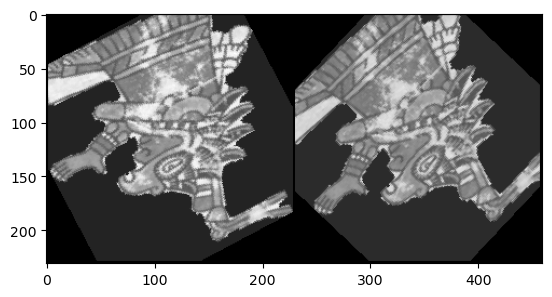

In [18]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [19]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [20]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
)

### Produce predictions and calculate accuracy of model

In [21]:
cnn.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = cnn(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(_)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

tensor([32.1908, 29.0583, 32.5980, 29.9832, 28.9536, 27.9770, 30.7700, 27.2929,
        29.3035, 30.0130, 32.9617, 28.4206, 28.4108, 29.3101, 26.8398, 28.5168,
        30.5137, 29.9061, 26.1658, 28.2142, 31.6747, 25.3742, 31.7659, 27.4314,
        31.6918, 27.0235, 31.9450, 30.6661, 26.0519, 30.0017, 32.3044, 29.8215,
        30.5553, 33.3016, 31.8631, 29.3679, 33.2317, 25.3040, 29.7910, 28.2146,
        30.0023, 29.3052], device='cuda:0')
Accuracy of the network on the 42 test images: 80 %


In [22]:
print(f"Predicted: {torch.tensor(predicted_list)}")
print(f"Truth    : {torch.tensor(target_list)}")

metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Truth    : tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Accuracy : 0.8095238208770752
Precision: 0.8095238208770752
Recall   : 1.0
F1       : 0.8947368264198303
